# This notebook is for the Fair-Shapely experiment

In [33]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [35]:
from src.data.unified_dataloader import load_dataset

a, processed_german_credit = load_dataset('german_credit')
# _, processed_uci = load_dataset('uci')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [36]:
processed_german_credit.head(3)

,Age,sex,Credit amount,Duration,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,2.766456,0,-0.745131,-1.236478,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,-1.191404,1,0.949817,2.248194,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
2,1.183312,0,-0.416562,-0.738668,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [37]:
'''UCI dataset'''
# df = processed_uci.copy()
# X = df.drop('income', axis=1)
# y = df['income']

'''German Credit dataset'''
df = processed_german_credit.copy()
X = df.drop('Risk', axis=1)
y = df['Risk']


In [38]:
from src.evaluation.five_fold_cross_validation import evaluate_model
model = XGBClassifier()
evaluate_model(model=model, X_train=X, y_train=y, num_folds=5, dataset_name='german_credit')

-------------------------------------
-------------1th fold----------------
-------------------------------------
1. Split the dataset into majority group and minority group (label 0 and label 1)
2. 初始化FairnessExplainer
--------接下来先对minority group进行修改--------
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用FairSHAP, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用FairSHAP, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
在X_train_minority中shapely value中大于0.1的值的个数有: 31
--------接下来对majority group进行修改--------
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
在X_train_majority中shapely value中大于0.1的值的个数有: 56
6. 计算original model

### 4. read saved_csv file and make plots

In [70]:
def extract_original_values(fold):
    original_DR = fold.loc[0,'new_DR']
    original_DP = fold.loc[0,'new_DP']
    original_EO = fold.loc[0,'new_EO']
    original_PQP = fold.loc[0,'new_PQP']
    return original_DR, original_DP, original_EO, original_PQP

In [71]:
''' german credit dataset '''

fold1 = pd.read_csv('saved_results/german_credit/1-fold_results.csv')
fold2 = pd.read_csv('saved_results/german_credit/2-fold_results.csv')
fold3 = pd.read_csv('saved_results/german_credit/3-fold_results.csv')
fold4 = pd.read_csv('saved_results/german_credit/4-fold_results.csv')
fold5 = pd.read_csv('saved_results/german_credit/5-fold_results.csv')

fold1_original_DR, fold1_original_DP, fold1_original_EO, fold1_original_PQP = extract_original_values(fold1)
fold2_original_DR, fold2_original_DP, fold2_original_EO, fold2_original_PQP = extract_original_values(fold2)
fold3_original_DR, fold3_original_DP, fold3_original_EO, fold3_original_PQP = extract_original_values(fold3)
fold4_original_DR, fold4_original_DP, fold4_original_EO, fold4_original_PQP = extract_original_values(fold4)
fold5_original_DR, fold5_original_DP, fold5_original_EO, fold5_original_PQP = extract_original_values(fold5)

fold1.drop(fold1.index[0], inplace=True)
fold2.drop(fold2.index[0], inplace=True)
fold3.drop(fold3.index[0], inplace=True)
fold4.drop(fold4.index[0], inplace=True)
fold5.drop(fold5.index[0], inplace=True)

fold1.head(3)

,action_number,new_DR,new_DP,new_EO,new_PQP
1,1,0.075637,0.005952,0.004202,0.000000
2,2,0.092114,0.069444,0.243697,0.181319
3,3,0.077462,0.076389,0.243697,0.162857


min_action:1, max_action:86
<class 'int'> <class 'int'>


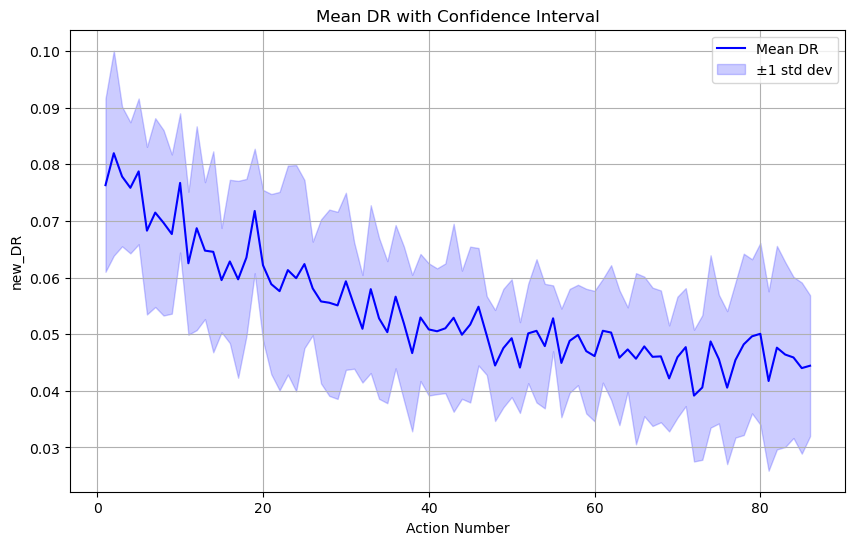

In [72]:
import matplotlib.pyplot as plt

for fold in [fold1, fold2, fold3, fold4, fold5]:
    fold['action_number'] = pd.to_numeric(fold['action_number'])

min_action = int(1)
max_action = min([
    len(fold1['action_number']),
    len(fold2['action_number']),
    len(fold3['action_number']),
    len(fold4['action_number']),
    len(fold5['action_number'])
])
print(f'min_action:{min_action}, max_action:{max_action}')
print(type(min_action), type(max_action))

# 创建一个包含所有可能action_number的列表
action_range = np.arange(min_action, max_action + 1)

# 创建一个字典来存储每个action_number对应的new_DR值
dr_values = {action: [] for action in action_range}

# 收集每个action_number对应的所有new_DR值
for fold in [fold1, fold2, fold3, fold4, fold5]:
    mask = (fold['action_number'] >= min_action) & (fold['action_number'] <= max_action)
    for action, dr in zip(fold.loc[mask, 'action_number'], fold.loc[mask, 'new_DR']):
        dr_values[action].append(dr)

# 计算每个action_number的均值和标准差
means = []
stds = []
for action in action_range:
    values = dr_values[action]
    means.append(np.mean(values))
    stds.append(np.std(values))

# 转换为numpy数组以便于计算
means = np.array(means)
stds = np.array(stds)

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制均值线
plt.plot(action_range, means, 'b-', label='Mean DR')

# 绘制填充区域（均值±标准差）
plt.fill_between(action_range, 
                 means - stds,
                 means + stds,
                 alpha=0.2,
                 color='b',
                 label='±1 std dev')

plt.xlabel('Action Number')
plt.ylabel('new_DR')
plt.title('Mean DR with Confidence Interval')
plt.legend()
plt.grid(True)

# 显示图形
plt.show()

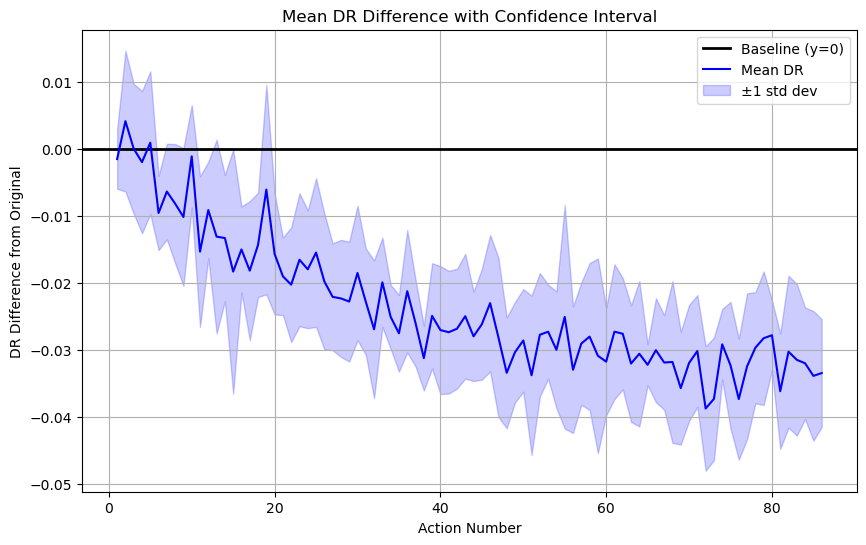

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 首先确保所有DataFrame中的action_number列都是数值类型
for fold in [fold1, fold2, fold3, fold4, fold5]:
    fold['action_number'] = pd.to_numeric(fold['action_number'])

# 减去各自的original_DR
fold1['new_DR'] = fold1['new_DR'] - fold1_original_DR
fold2['new_DR'] = fold2['new_DR'] - fold2_original_DR
fold3['new_DR'] = fold3['new_DR'] - fold3_original_DR
fold4['new_DR'] = fold4['new_DR'] - fold4_original_DR
fold5['new_DR'] = fold5['new_DR'] - fold5_original_DR

# 找到最小的action_number范围
min_action = max([
    fold1['action_number'].min(),
    fold2['action_number'].min(),
    fold3['action_number'].min(),
    fold4['action_number'].min(),
    fold5['action_number'].min()
])

max_action = min([
    fold1['action_number'].max(),
    fold2['action_number'].max(),
    fold3['action_number'].max(),
    fold4['action_number'].max(),
    fold5['action_number'].max()
])

# 创建一个包含所有可能action_number的列表
action_range = np.arange(min_action, max_action + 1)

# 创建一个字典来存储每个action_number对应的new_DR值
dr_values = {action: [] for action in action_range}

# 收集每个action_number对应的所有new_DR值
for fold in [fold1, fold2, fold3, fold4, fold5]:
    mask = (fold['action_number'] >= min_action) & (fold['action_number'] <= max_action)
    for action, dr in zip(fold.loc[mask, 'action_number'], fold.loc[mask, 'new_DR']):
        dr_values[action].append(dr)

# 计算每个action_number的均值和标准差
means = []
stds = []
for action in action_range:
    values = dr_values[action]
    means.append(np.mean(values))
    stds.append(np.std(values))

# 转换为numpy数组以便于计算
means = np.array(means)
stds = np.array(stds)

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制加粗的y=0基准线
plt.axhline(y=0, color='black', linewidth=2, linestyle='-', label='Baseline (y=0)')

# 绘制均值线
plt.plot(action_range, means, 'b-', label='Mean DR')

# 绘制填充区域（均值±标准差）
plt.fill_between(action_range, 
                 means - stds,
                 means + stds,
                 alpha=0.2,
                 color='b',
                 label='±1 std dev')

plt.xlabel('Action Number')
plt.ylabel('DR Difference from Original')
plt.title('Mean DR Difference with Confidence Interval')
plt.legend()
plt.grid(True)

# 显示图形
plt.show()